In [12]:
# Turned out it's probably an age related effect
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from bold_dementia.utils.configuration import get_config
from neuroginius.atlas import Atlas
from neuroginius.plotting import plot_matrix

config = get_config()

conn_dir = config["connectivity_matrices"]
ATLAS = "schaefer200"

atlas = Atlas.from_name(ATLAS, soft=False)

In [13]:
import joblib
import pandas as pd
import numpy as np


def make_longitudinal_data(conn_dir, atlas, k):
    matrices = joblib.load(f"{conn_dir}/atlas-{atlas}_gpugin/connectivities.joblib")
    metadata = pd.read_csv(f"{conn_dir}/atlas-{atlas}_gpugin/metadata.csv", index_col=0)
    labels = pd.read_csv(f"/georges/memento/BIDS/cluster_{k}_labels.csv", index_col=0)


    metadata = metadata.merge(
        right=labels,
        how="left", # Preserves order of the left key
        on="NUM_ID",
        validate="many_to_one"
    )

    no_psych_mask = metadata.cluster_label.isna()
    print(
        f"Dropping {no_psych_mask.sum()} subjects because of lacking MMMSE"
    )

    metadata = metadata[np.logical_not(no_psych_mask)]
    matrices = matrices[np.logical_not(no_psych_mask)]

    return matrices, metadata

In [14]:
matrices, metadata = make_longitudinal_data(conn_dir, "schaefer200", 3)
metadata = metadata.reset_index(drop=True)

Dropping 22 subjects because of lacking MMMSE


In [ ]:
from scipy.special import expit

class EnsembleClassifier:
    """
    Ensemble already fitted models
    """
    def __init__(self, models) -> None:
        self.models = models

    def predict_proba(self, X):
        n_preds = len(X)
        predictions = []
        for model in self.models:
            # We cannot use predict proba as it tends to
            # give nans for some reason
            predictions.append(expit(model.decision_function(X)))

        predictions = np.stack(predictions, axis=0).mean(axis=0)
        probas = predictions / predictions.sum(axis=1).reshape((n_preds, 1))
        return probas

estimators = []
for i in range(8):
    estimators.append(joblib.load(f"fitted_models/estimator_{i}.joblib"))
eclf = EnsembleClassifier(estimators)

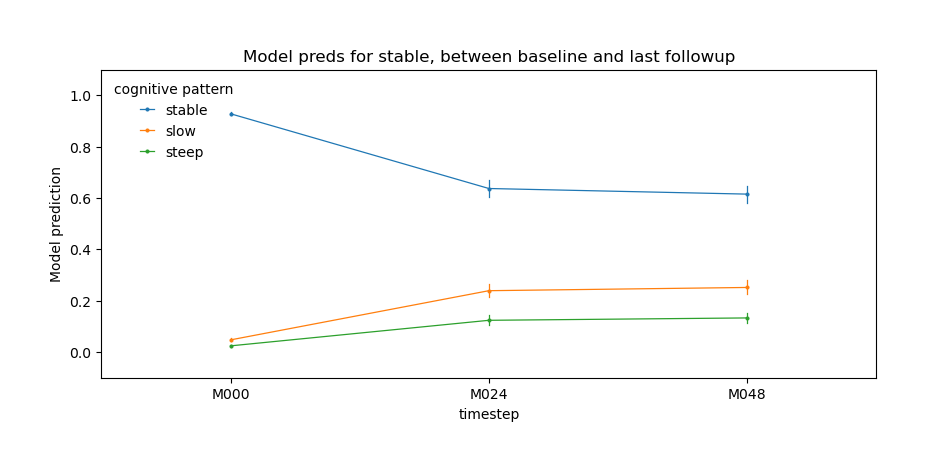

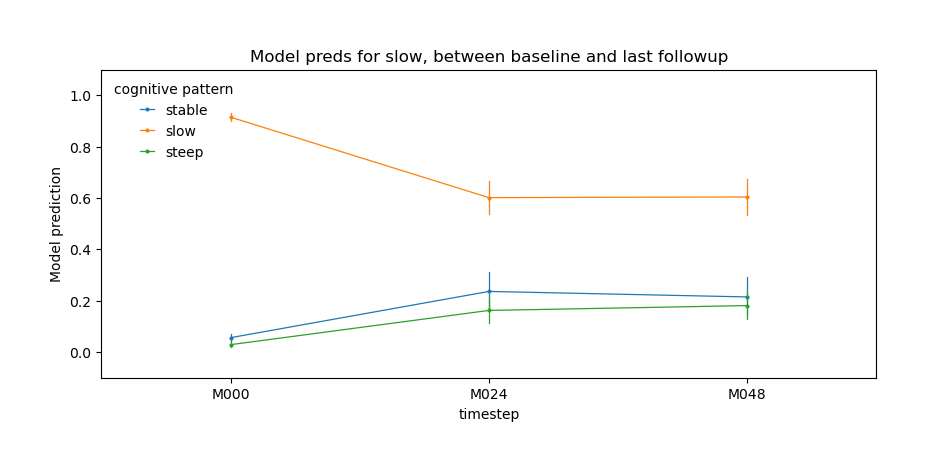

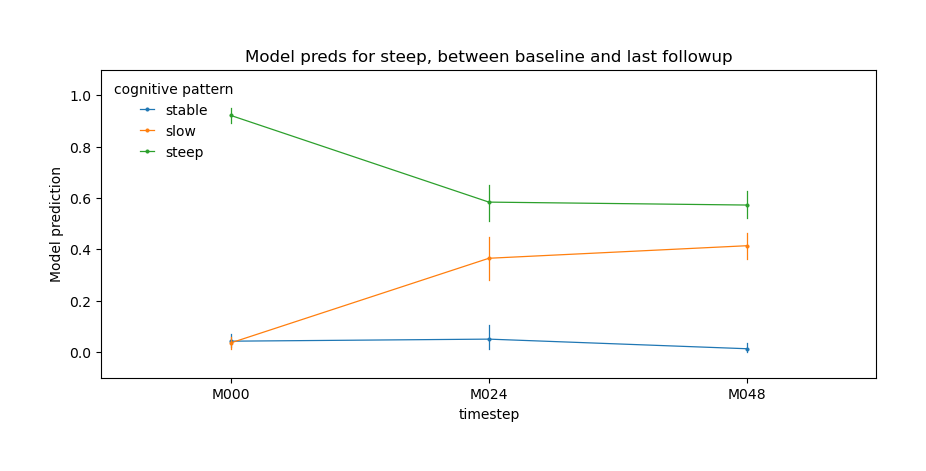

In [57]:
cats = ("stable", "slow", "steep")
preds = eclf.predict_proba(matrices)

for i in range(3):

    # We look for subjects which have all the timesteps
    end_msk = (metadata.cluster_label == i) & (metadata.ses == "M048")
    middle_msk = (metadata.cluster_label == i) & (metadata.ses == "M024")
    start_msk = (metadata.cluster_label == i) & (metadata.ses == "M000")

    end_subjects = metadata.loc[end_msk, "sub"].values
    middle_subjects = metadata.loc[middle_msk, "sub"].values
    start_subjects = metadata.loc[start_msk, "sub"].values

    complete_subjects = sorted(
        tuple(set(list(end_subjects)).intersection(set(start_subjects)).intersection(set(middle_subjects)))
    )

    complete_subj_msk = metadata["sub"].isin(complete_subjects)
    idx_48 = metadata[(metadata.ses == "M048") & complete_subj_msk].index.values
    idx_24 = metadata[(metadata.ses == "M024") & complete_subj_msk].index.values
    idx_00 = metadata[(metadata.ses == "M000") & complete_subj_msk].index.values

    M000 = pd.DataFrame(preds[idx_00], columns=["stable", "slow", "steep"])
    M000["timestep"] = "M000"
    M024 = pd.DataFrame(preds[idx_24], columns=["stable", "slow", "steep"])
    M024["timestep"] = "M024"
    M048 = pd.DataFrame(preds[idx_48], columns=["stable", "slow", "steep"])
    M048["timestep"] = "M048"
    df = pd.concat((M000, M024, M048))

    plt.subplots(figsize=(10, 4))
    m = df.melt(id_vars="timestep", value_name="Model prediction", var_name="cognitive pattern")
    sns.pointplot(m, x="timestep", y="Model prediction", hue="cognitive pattern", alpha=1)
    plt.title(f"Model preds for {cats[i]} subjects, between baseline and last followup")
    plt.ylim(-0.1, 1.1)
    plt.show()

In [53]:
sample_a = df.loc[df.timestep == "M000", "steep"]
sample_b = df.loc[df.timestep == "M048", "steep"]

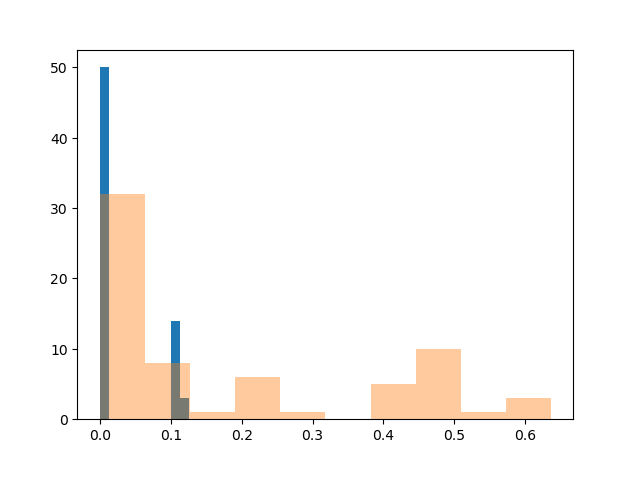

TtestResult(statistic=np.float64(-5.620672874917807), pvalue=np.float64(3.2788786054592827e-07), df=np.float64(73.00903412292978))

In [54]:
from scipy.stats import ttest_ind
plt.hist(sample_a)
plt.hist(sample_b, alpha=0.4)
plt.show()
ttest_ind(sample_a, sample_b, equal_var=False)